### Still plugging away... 

It's time to get to (prepping for) audio

In [1]:
# Just your usual setup

import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fdls
import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# It's optimal if this is a power of 2.  For CPU use 16K appears best.
blocklenk = 16
blocklen = (blocklenk * 1024)

# hilbert_filter_terms has a direct impact on filter delays
hilbert_filter_terms = 1024
# typically the most delay added is 128 (NTSC chroma bandpass) but best to be safe for now
blockcut = hilbert_filter_terms + 192

In [3]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

# TODO: merge with below
def doplot(B, A, freq = 40, extra = None, whole = False):
    w, h = sps.freqz(B, A, whole = whole)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def plotfilt(filterset, key, power = 1.0, extra = None):
    # take the first half of the FFT multiplier
    h = filterset[key] ** power
    h = h[0:len(h)//2]
    
    freq = filterset['freq'] / 2
    w = np.arange(0, freq, freq / len(h))

    db = 20 * np.log10(abs(h))
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

# Draws a uint16 image, downscaled to uint8
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

# IEC 60857 9.2.2: the range from -40 to 100 IRE is 1.7mhz, with 0 at 8.1mhz.  Maximum is 110IRE.
NTSC_hz_ire = 1700000 / 140.0

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match legacy ld-decode scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    # (note:  i don't know how to handle these values perfectly yet!)
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 350000,
    'audio_filtorder': 2,

    # This BPF similar but not *quite* identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    
    # The PAL spec does not use IRE but rather voltage.
    'videorf_0ire': 7100000, # the sync signal peaks about here at full saturation
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    


In [5]:
#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
polar2z = lambda r,θ: r * np.exp( 1j * θ )
deg2rad = lambda θ: θ * (np.pi / 180)

In [6]:
# Load up default parameters

params = {'freq': 40, 'blocklen': blocklen}

for p in [SysParams_NTSC]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]
        
params['MTF'] = sps.zpk2tf(.1, -.5, 1.65)
params['MTF'] = sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)

In [7]:
# (mostly the) old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140

hz_ire_scale = 1700000 / 140

# NTSC
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [8]:
hz0ire = params['videorf_0ire']

In [9]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return hz0ire + (hz_ire_scale * ire)

def hztoire(hz):
    return (hz - hz0ire) / hz_ire_scale

m20ire = iretohz(-20)

def calczc(data, _start_offset, target, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [10]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter offsets.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [11]:
# This filter (attempts to) compensate for phase distortion from the 2-pole elliptical filter
# on the DD 3.0 board.  It still needs some development work, but a little phase adjustment
# goes a long way to improve colors
def calculate_dd_filter(params):
    filterdata = pd.read_csv('dd30phase.csv').iloc[:]
    # add an ending to try to keep freq response closer to even
    filterdata.loc[65] = [20000000, 144]

    ffreq = (filterdata.hz / (params['freq_hz'] / 2)) * np.pi

    fphase = (filterdata.phase) * (np.pi / 180)
    flevela = np.ones_like(fphase)

    fphase[58:] += (np.pi* 2)

    cut = 0
    cutend = len(ffreq)-0
    _level = 1
    _shift = -.02
    dimb = 1
    dima = 3
    [fb, fa] = fdls.FDLS(dimb, dima, ffreq[cut:cutend], np.ones_like(ffreq[cut:cutend]), fphase[cut:cutend]*_level, shift=_shift)

    return fb, fa



In [12]:
# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    blocklen = params['blocklen']
    
    SP['hilbert_filter_terms'] = hilbert_filter_terms
    
    # build up a couple more constants
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF filter, which will get the audio notch filters added if needed
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'), blocklen)
    
    # If there is analog audio, it must be filtered well especially with DD >=3.0-beta RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    #tmp = filtfft([fb, fa], blocklen)
    #SP['FRFVideo'] *= tmp
    
    #SP['FRFVideo'] *= exp
    
    SP['Fhilbert'] = np.fft.fft(hilbert_filter, blocklen)
    
    SP['Fdd'] = filtfft(calculate_dd_filter(SP), blocklen)
    
    # This MTF filter needs A LOT of work!
    #[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.65)
    SP['Fmtf'] = filtfft(SP['MTF'], blocklen)
    
    # The above is multiplied with a Hilbert transform to get (partway) to demodulation
    
    # The 4.2-4.6mhz (NTSC)/5.x mhz (PAL) demodulated lowpass filter
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'), blocklen) # standard 4.Xmhz

    # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10), -SP['deemp'][0]*(10**-10), SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)

    # The direct opposite of the above, used in test signal generation
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10), -SP['deemp'][1]*(10**-10), SP['deemp'][1] / SP['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(4, 0.5/freq_half, 'low'), blocklen) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fburst_len'] = int(np.ceil((18 * freq_half / SP['fsc_mhz']) / 2) * 2)
        SP['Fburst_delay'] = SP['Fburst_len'] // 2
#        print(SP['Fburst_len'])
        bf = sps.firwin(SP['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fburst'] = filtfft((bf, [1.0]), blocklen)
        SP['imglen'] = (int)((SP['freq_hz'] / 59.976) * 1.25)
    else:
        # For PAL this is a 3.75mhz filter
        SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f, blocklen)
    
    return SP

In [13]:
# The actual video demodulation code

def dodemod(paramsc, data, mtf_level = 0, dd_level = 1.0, cutarf = False, return_fft = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if mtf_level != 0:
        indata_fft_filt *= paramsc['Fmtf'] ** mtf_level

    if dd_level != 0:
        indata_fft_filt *= paramsc['Fdd'] ** dd_level
        
        
    hilbert = np.fft.ifft(indata_fft_filt * paramsc['Fhilbert'])

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * paramsc['FPsync']).real
    
    rv = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    if return_fft:
        return rv, indata_fft_filt, demod_fft
    else:
        return rv
    #return out_video, out_video05, out_videoburst

In [14]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9850000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [15]:
# note: currently returns PSNR assuming IRE==100
def calcsnr(a):
    #stdire = np.std(a) / NTSC_hz_ire
    #return(20 * np.log10(100 / stdire))
    
    signal = hztoire(np.mean(a))
    noise = np.std(a) / hz_ire_scale
    #print(signal, noise)
    return 20 * np.log10(70 / noise)


In [16]:
# Scaler code in Python is horribly slow - numpy is a bit less so

# Thankfully for bit unpacking there are numpy routines to operate on bit arrays...
def load_packed_data(infile, sample, readlen = blocklen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + blocklen]

In [17]:
def loaddata(infile, sample):

    # packed data is a bit more complicated
    if sampletype == 3:
        return load_packed_data(infile, sample)

    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(blocklen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata


In [18]:
def demod(infile, _start, _end, filterset, mtf_level = 0.0, dd_level = 1.0, retraw = False):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = int(_end)
    
    if (_start > blockcut):
        start = int(_start - blockcut)
    else:
        start = 0 # should this be an error?  prolly.

    #print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        indata = loaddata(infile, i)
        if indata is None:
            break
        
        tmp = dodemod(filterset, indata, mtf_level, dd_level)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    if retraw:
        return output, indata
    else:
        return output
    

In [19]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [20]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out

In [21]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(filterset['blocklen'], dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    # Determine filter lag (mostly the length of the hilbert filter)
    filterset['dgap'] = calczc(fakedecode['demod'], 950, iretohz(-20), 256 + hilbert_filter_terms) - calczc(fakeoutput_emp, 950, iretohz(-20), 500)

    # Now use above to calc the lag of the 0.5mhz filter
    dgap05_1 = calczc(fakedecode['demod_05'], 900 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 900 + filterset['dgap'], iretohz(-20), 500)
    dgap05_2 = calczc(fakedecode['demod_05'], 1250 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 1250 + filterset['dgap'], iretohz(-20), 500)
    filterset['dgap_05'] = (dgap05_1 + dgap05_2) / 2

    fdburst_adj = fakedecode['demod_burst'][filterset['Fburst_delay']:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

In [22]:
def pxtousec(px, freq = 40000000):
    return (px / freq) * 1000000

def usectopx(usec, freq = 40000000):
    return freq * usec / 1000000

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [23]:
def findfirstframe(infile, start = 0):

    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
#        print(loc)
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
            if (np.argmax(data['demod_sync']) / filterset['line_px']) < 16:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        #print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        #print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and firstfield:
            loc += int(240 * filterset['line_px'])
            #return loc + nextline, data
        elif syncloc and not firstfield:
            return loc + nextline, data
        else:
            loc += int(120 * filterset['line_px'])
    
    return None

In [24]:
# note:  this VBI decoder works with unscaled lines.
def decodephillipscode(data, linestart):
    #print(linestart)
    curzc = calczc(data, int(linestart + usectopx(2)), iretohz(50), int(usectopx(12)))

    zc = []
    while curzc is not None:
        zc.append((curzc, data[int(curzc - usectopx(0.5))] < iretohz(50)))
        curzc = calczc(data, curzc+usectopx(1.9), iretohz(50), int(usectopx(0.2)))

    usecgap = pxtousec(np.diff([z[0] for z in zc]))
    valid = len(zc) == 24 and np.min(usecgap) > 1.85 and np.max(usecgap) < 2.15

    if valid:
        bitset = [z[1] for z in zc]
        linecode = []
        for b in range(0, 24, 4):
            linecode.append((np.packbits(bitset[b:b+4]) >> 4)[0])
        #print(bitset)
        #print(linecode)
        return linecode
    else:
        return None
    
def processphillipscode(data, lines):
    rv = {'codes': []}
#    codes = []
    for l in range(6, 10):
        lc = decodephillipscode(data, lines[l])
        if lc is not None:
            rv['codes'].append((l, lc))
            if lc[0] == 15: # frame code
                if lc[2] == 13: # CLV
                    print('CLV')
                    rv['frame'] = -1
                else: # CAV
                    frame = (lc[1] & 7) * 10000
                    frame += (lc[2] * 1000)
                    frame += (lc[3] * 100)
                    frame += (lc[4] * 10)
                    frame += lc[5] 
                    print('CAV frame #', frame)
                    rv['frame'] = frame
                    
    return rv

In [25]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [26]:
def downscale_field(data, lineinfo, outwidth=1820):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor

In [61]:
def inpicture(linenum):
    if linenum is None:
        return False
    
    return inrange(linenum, 10, 263.4) or inrange(linenum, 273, 525)

# this still needs to be simplified... 
def findsync_getpulses(frame, start, line_px = 2540, lines = 525):
    curloc = start
    ilinepx = int(line_px)
    
    output = frame['demod']
    output_sync = frame['demod_sync']

    lastline = start
    linenum = None
    lineinfo = {}
    
    sstart = 0
    send = int(line_px)
    
    # Check every half-line for equalization pulses
    
    while linenum is None or (linenum <= 526 and ((curloc - lastline) < (lines * line_px))):
        offset = np.argmax(output_sync[curloc + sstart:curloc + send])
        lineloc = curloc + sstart + offset
        
        #lineloc = int(np.round(calczc(frame['demod'], lineloc-300, iretohz(-20), 500)))

        synclevel = output_sync[lineloc]
        
        print(linenum, inpicture(linenum), curloc, offset, lineloc, lineloc - lastline, synclevel)

        # the adjustment factor is set per line type - calibrated against an acutal disk
        adjustment = 0
        if inrange(synclevel, 0.65, 0.8) or (inpicture(linenum) and inrange(synclevel, 0.3, 0.85)): # regular line
            # find the zero crossing of the non-filtered demod signal... or interpolate if this is wrong
            try:
                lineloc = int(np.round(calczc(output, lineloc - 10, iretohz(-20), 30)))
            except:
                lineloc = lineinfo[linenum - 1]  + (lineinfo[linenum - 1] - lineinfo[linenum - 2])
                #None

            sstart = int(line_px * .45)
            send = int(line_px * .55)
            
            lastline = lineloc
            # If we're in the middle of a frame, don't scan mid-lines
            if linenum is not None and inpicture(linenum):
                curloc = lineloc + int(line_px * .5)
            else:
                curloc = lineloc
                
        elif inrange(synclevel, 0.4, 0.65): # equalization pulse - before and after vsync
            if not inrange(lineloc - lastline, line_px * .95, line_px * 1.05) and linenum is None:
                return None, curloc + (ilinepx * 250)
            elif linenum is None:
                linenum = 1
            # adjust to match observed color burst timing
            adjustment = int(usectopx(2.4))
            curloc = lineloc
        elif inrange(synclevel, 0.8, 1.01): # vsync
            # vsync - DO NOT use the peak filtered sync here, it is going to be way off!
            lineloc = int(np.round(calczc(frame['demod'], lineloc-500, iretohz(-20), 900)))
            adjustment = int(usectopx(4.65))
            curloc += int(line_px * .5)
        else: # probably middle of regular line
            curloc += int(line_px * .5)
            
        if linenum is not None:
            # save integers if not a half-line
            if np.abs(linenum - np.int(linenum)) > .1:
                lineinfo[linenum] = lineloc
                print(linenum, lineloc)
            else:
                lineinfo[int(linenum)] = lineloc + adjustment
                print(linenum, lineloc + adjustment)
                
        if linenum is not None:
            if inpicture(linenum):
                linenum += 1.0
            else:
                linenum += 0.5

        
    return lineinfo, lineinfo[520]

#linelocs, end = findsync(frame, 0)

# this needs *a lot* of cleaning up
def cburstalign(frame, lineinfo, badburst, shift33 = -((33.0 / 360.0) * np.pi)):
    lineinfo_tmpa = lineinfo.copy()
    offset = 0
    
    output = frame['demod']
    output_burst = frame['demod_burst']
    
    peak = []
    cuts = []
    for l in range(1, 525):
        if badburst[l]:
            #lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue
        
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()
        
        peak.append(np.argmax(np.abs(cut)))
        
    peak = np.array(peak)
    peakmean = peak.mean()
    
    zc = []
    linelens = []
    for l in range(1, 525):
        if badburst[l]:
            continue

        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        #zc.append(calczc(cut, np.floor(peakmean), 0, 5))
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        try:
            zc.append(calczc(cut, np.floor(peakmean), 0, 5) * (outwidth / linelen))
            linelens.append(lineinfo_tmpa[l + 1] - lineinfo_tmpa[l])
        except:
            None
        
    print("zcmean ", np.mean(zc), np.mean(zc) * (outwidth / np.mean(linelens)))
        
    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, 525):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        try:
            adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (outwidth / linelen)
        except:
            print('bad burst', l, lineinfo[l], lineinfo2[l], tmp)
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offsets[l - 1] - filterset['dgap_burst']
            continue

        # find the nearest odd # for the peak crossover.
        target = (np.round((adjpeak - 1) / 2) * 2) + 1
        offsets[l] = (adjpeak - target)

        #print('fs ', l, np.argmax(cut), adjpeak, target,  offsets[l], lineinfo2[l], lineinfo_tmpa[l], lineinfo_tmpa[l] - lineinfo_tmpa[l - 1])
            
    if np.mean(np.abs(offsets)) > .8:
        print("WARNING: offsets too high")
            
    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, 524):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l, offsets[l - 1:l + 2])
            if offsets[l] > 0:
                offsets[l] -= outfsc // 2
            else:
                offsets[l] += outfsc // 2
            
    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(1, 525):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / outwidth)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / outwidth)) #- filterset['dgap_burst']    

    return lineinfo_tmpa, lineinfo_cphaseadj, offsets

badburst = np.zeros(526)
#linelocs2, linelocs2_phaseadj, offsets = cburstalign(frame, linelocs, badburst)

In [63]:
if True: # DD 3.0
    params['freq'] = 40.0
    
    deemp_adj1 = .34
    deemp_adj2 = .34

    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 2
    params['vlpf_freq'] = 4400000
    params['vlpf_order'] = 5    

    # use w/ac3 disks
    #params['audio_rfreq'] = 2900000

filterset = prepare_video_filters(params)
dg = calc_demodgaps(filterset)
imglen = filterset['imglen']

In [66]:
firstloc = 1024 * 1024 * 0
#infile = open('/home/cpage/ilovela.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/erica.raw', 'rb')
infile = open('/mnt2/ld/st6-praxis.raw', 'rb')
#infile = open('/home/cpage/avs50819.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/ve_tp.raw', 'rb')
#infile = open('/mnt2/ld/giu8x.raw', 'rb')

#infile = open('/mnt2/ld/dd/he010_6x.raw', 'rb')
firstloc = 1024 * 1024 * 5000 # 3908 - boat
firstloc = 1024 * 1024 * 11000 # 8621 - hotel wall
firstloc = 1024 * 1024 * 10200 # 7994 - girl smile
firstloc = 1024 * 1024 * 9500 # 7994 - girl smile
#firstloc = 1024 * 1024 * 500

#infile = open('/mnt2/ld/dd/he010_6x-ch4.raw', 'rb')
#firstloc = 1024 * 1024 * 35000
#infile = open('/mnt2/ld/ggv1001-s1.r30', 'rb')
#firstloc = 1024 * 1024 * 50000 # frame 39288
#firstloc = 1024 * 1024 * 68000 # frame 53430

#infile = open('/mnt2/ld/ve-test.r30', 'rb')
#firstloc = 1024 * 1024 * 14000 #40315 - girl against grafitti
#firstloc = 1024 * 1024 * 10000 #37446 - girl against wall
#firstloc = 1024 * 1024 * 11500 #38482 - water/tree

#infile = open('/mnt2/ld/ve-test.r30', 'rb')
#infile = open('/home/cpage/videosketches.raw', 'rb')

#infile = open('/home/cpage/ldcaps3/avs4x_monitor.raw', 'rb')
firstloc = 1024 * 1024 * 451

sampletype = 2

In [ ]:
outfsc = 4
outwidth = int(outfsc * 227.5)

ilinepx = filterset['line_px']

needmtf = .5
rdata = None

# by reading two frames at once, it will be necessary to do one demod call
lines = 1100
ilinepx = int(filterset['line_px'])
readlen = lines * ilinepx

start = 0

frame = demod(infile, start, start + readlen, filterset)

In [71]:
linelist = None
curloc = 0
while linelist is None:
    linelist, curloc = findsync_getpulses(frame, curloc)

None False 0 1649 1649 1649 0.765210709964
None False 1650 0 2793 1143 9.63510303877e-05
None False 2920 129 4192 2542 0.765210710014
None False 4193 0 5336 1143 9.63510303905e-05
None False 5463 129 6735 2542 0.765210710014
None False 6736 0 7879 1143 9.63510303903e-05
None False 8006 128 9277 2541 0.763359399647
None False 9279 0 10422 1143 9.53671499629e-05
None False 10549 128 11820 2541 0.76335939963
None False 11822 0 12965 1143 9.53671499623e-05
None False 13092 128 14363 2541 0.76335939963
None False 14365 0 15508 1143 9.87165428653e-05
None False 15635 129 16907 2542 0.765210710054
None False 16908 0 18051 1143 9.6351030399e-05
None False 18178 128 19449 2541 0.765210710027
None False 19451 0 20594 1143 9.5597247393e-05
None False 20721 128 21992 2541 0.765210710014
None False 21993 0 23136 1143 9.63510303903e-05
None False 23263 129 24535 2542 0.765210710014
None False 24537 0 25680 1143 9.55972473926e-05
None False 25807 128 27078 2541 0.765210710014
None False 27080 0 28223

None False 277540 128 278811 2541 0.763359399647
None False 278813 0 279956 1143 9.53671499622e-05
None False 280083 127 281353 2540 0.763359399643
None False 281355 0 282498 1143 9.53671499625e-05
None False 282625 128 283896 2541 0.76521071001
None False 283897 0 285040 1143 9.6351030392e-05
None False 285167 128 286438 2541 0.763359399647
None False 286439 0 287582 1143 9.61191186483e-05
None False 287709 128 288980 2541 0.763359418012
None False 288981 0 290124 1143 9.61191209495e-05
None False 290251 129 291523 2542 0.76521071001
None False 291524 0 292667 1143 9.63510303901e-05
None False 292794 128 294065 2541 0.765210710027
None False 294066 0 295209 1143 9.63510303925e-05
None False 295336 128 296607 2541 0.765210710027
None False 296608 0 297751 1143 9.63510303933e-05
None False 297878 129 299150 2542 0.765210710014
None False 299151 0 300294 1143 9.63510303924e-05
None False 300421 128 301692 2541 0.765210710027
None False 301693 0 302836 1143 9.63510303947e-05
None False 30

55.0 True 1390921 129 1392193 2542 0.765210710014
55.0 1392194
56.0 True 1393464 129 1394736 2542 0.765210710014
56.0 1394738
57.0 True 1396008 128 1397279 2541 0.765210710015
57.0 1397281
58.0 True 1398551 128 1399822 2541 0.763359399634
58.0 1399824
59.0 True 1401094 129 1402366 2542 0.765210709997
59.0 1402367
60.0 True 1403637 129 1404909 2542 0.765210710014
60.0 1404910
61.0 True 1406180 129 1407452 2542 0.765210710014
61.0 1407454
62.0 True 1408724 128 1409995 2541 0.763359399634
62.0 1409996
63.0 True 1411266 130 1412539 2543 0.765210709998
63.0 1412540
64.0 True 1413810 128 1415081 2541 0.763359399647
64.0 1415083
65.0 True 1416353 129 1417625 2542 0.765210709997
65.0 1417626
66.0 True 1418896 129 1420168 2542 0.765210710014
66.0 1420170
67.0 True 1421440 129 1422712 2542 0.767047537025
67.0 1422713
68.0 True 1423983 129 1425255 2542 0.765210710018
68.0 1425256
69.0 True 1426526 129 1427798 2542 0.765210710044
69.0 1427800
70.0 True 1429070 128 1430341 2541 0.765210710014
70.0 

246.0 True 1876599 128 1877870 2541 0.763359399647
246.0 1877871
247.0 True 1879141 128 1880412 2541 0.763359399643
247.0 1880414
248.0 True 1881684 128 1882955 2541 0.76521071001
248.0 1882956
249.0 True 1884226 128 1885497 2541 0.765210710027
249.0 1885498
250.0 True 1886768 128 1888039 2541 0.763359399647
250.0 1888041
251.0 True 1889311 128 1890582 2541 0.76521071001
251.0 1890583
252.0 True 1891853 128 1893124 2541 0.765210710027
252.0 1893125
253.0 True 1894395 128 1895666 2541 0.765210710027
253.0 1895667
254.0 True 1896937 127 1898207 2540 0.761493491724
254.0 1898209
255.0 True 1899479 128 1900750 2541 0.765210710006
255.0 1900751
256.0 True 1902021 128 1903292 2541 0.763359399647
256.0 1903294
257.0 True 1904564 127 1905834 2540 0.763359399643
257.0 1905835
258.0 True 1907105 129 1908377 2542 0.765210710049
258.0 1908378
259.0 True 1909648 128 1910919 2541 0.765210710027
259.0 1910920
260.0 True 1912190 128 1913461 2541 0.765210710027
260.0 1913462
261.0 True 1914732 128 1916

In [74]:
badburst = np.zeros(526)
linelist2, linelist2_phaseadj, offsets = cburstalign(frame, linelist, badburst)

zcmean  31.1880066327 11.1644783926


(477750,)
uint8 (525, 910) (525, 910)


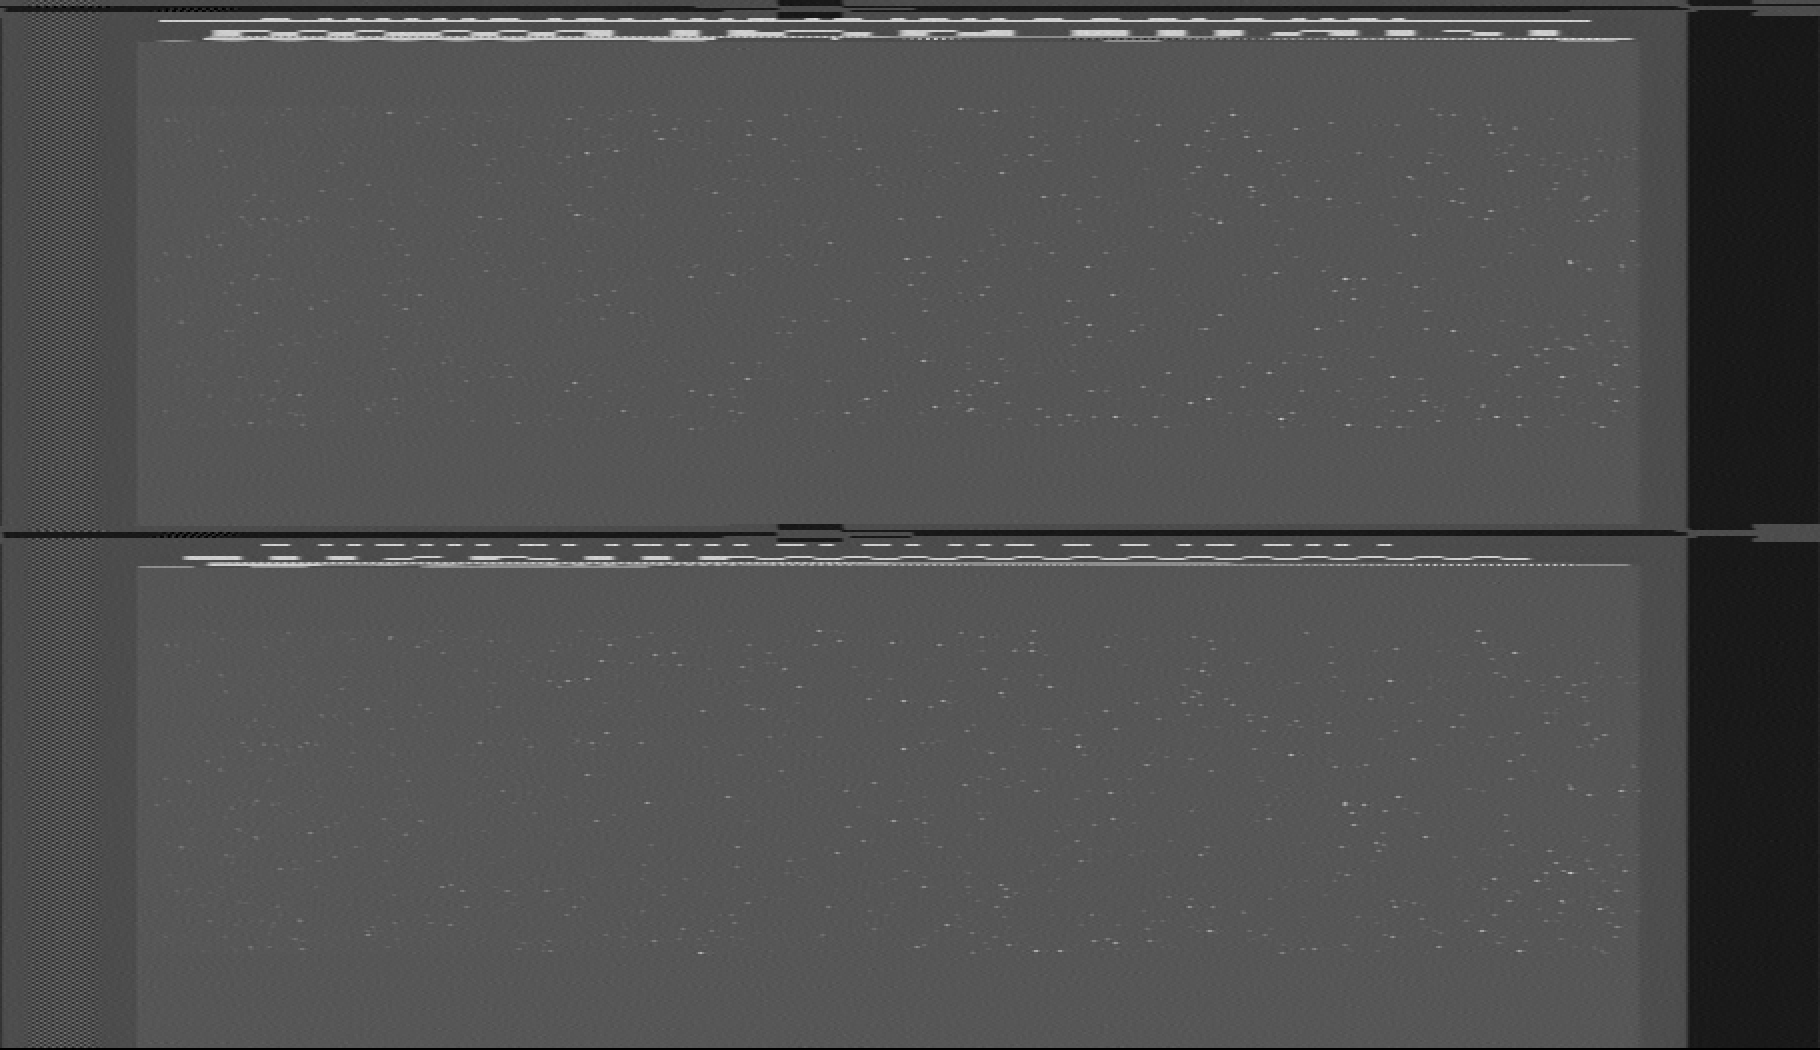

In [75]:
ll = []
outwidth = 910
dsout = np.zeros((525 * outwidth), dtype=np.double)    
for l in range(1, 525):
    ll.append(linelist2[l])
    dsout[(l - 1) * outwidth: l * outwidth] = scale(frame['demod'], linelist2[l], linelist2[l+1], outwidth)

reduced = (dsout - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, outwidth, 525, hscale=2, vscale=2)

In [ ]:
def formatoutput(lines, lines_odd_cburst, lines_even_cburst):
    outwidth = 910

    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 503, 2):
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = lines_even[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]
        combined[((i + 1) * outwidth):((i + 2) * outwidth)] = lines_odd[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]

    reduced = (combined - minn) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    for i in range(0, 504, 2):
        if not lines_even_cburst[i // 2][0]:
            lines16[((i + 0) * outwidth)] = 16384
        else:
            lines16[((i + 0) * outwidth)] = 32768

        clevel = .58

        lines16[((i + 0) * outwidth) + 1] = np.uint16(327.67 * clevel * lines_even_cburst[i // 2][1])

        if not lines_odd_cburst[i // 2][0]:
            lines16[((i + 1) * outwidth)] = 16384
        else:
            lines16[((i + 1) * outwidth)] = 32768

        lines16[((i + 1) * outwidth) + 1] = np.uint16(327.67 * clevel * lines_odd_cburst[i // 2][1])

    #drawdata(lines16, outwidth, 506, hscale=2, vscale=2)
    
    frameout = np.zeros((844 * 505), dtype=np.uint16)
    offset = -8

    for i in range(1, 505):
        frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]
        frameout[(i + 0) * 844: ((i + 0) * 844) + 2] = lines16[((i + 0) * 910): ((i + 0) * 910) + 2]

    #outfile = open('tmp.tbc', 'wb')
    #outfile.write(frameout)
    
    return combined, lines16, frameout

In [69]:
linelist

[]

In [56]:
rv[1]

2586910

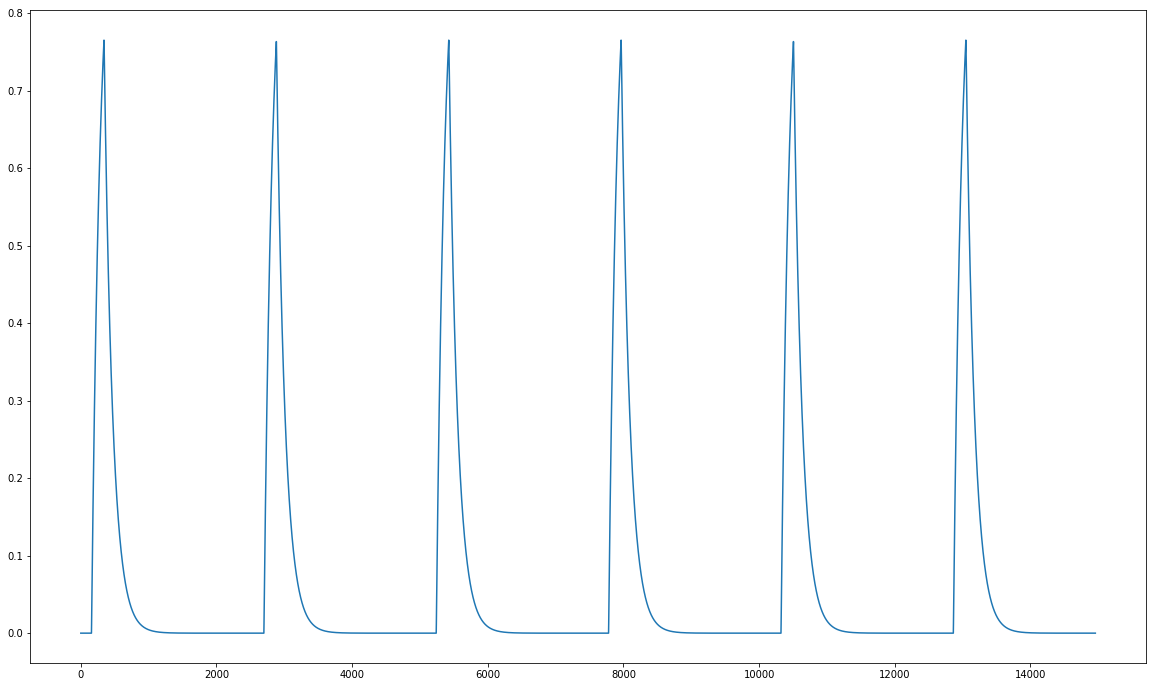

In [43]:
plt.plot(frame['demod_sync'][525041:540000])

In [40]:

def findfirstframe(infile, filterset, start = 0, lines = 1100):

    # by reading two frames at once, it will be necessary to do one demod call
    ilinepx = int(filterset['line_px'])
    readlen = lines * ilinepx

    frame = demod(infile, start, start + readlen, filterset)

    for l in range(0, lines, 100):
        subset = frame['demod_sync'][l * ilinepx: (l + 100) * ilinepx]
        if np.max(subset) > .9:
            testloc = (l * ilinepx) + np.argmax(subset) - (ilinepx * 30)
            
            rv = findsync_getpulses(frame, testloc)
            if rv[0] is not None:
                return rv, frame

    print("nothing found")
    return frame

outfsc = 4
outwidth = int(outfsc * 227.5)

ilinepx = filterset['line_px']

needmtf = .5
rdata = None

rv = findfirstframe(infile, filterset)


None False 525041 0 526184 526184 0.00142502051011
None False 526311 0 527454 527454 6.6356218742e-08
None False 527581 0 528724 528724 0.00143279978475
None False 528851 0 529994 529994 6.67184617623e-08
None False 530121 0 531264 531264 0.00145927588289
None False 531391 0 532534 532534 6.79513279533e-08
None False 532661 0 533804 533804 0.00147049996649
None False 533931 0 535074 535074 6.84739789036e-08
None False 535201 0 536344 536344 0.00147852751624
None False 536471 0 537614 537614 6.88477827526e-08
None False 537741 0 538884 538884 0.00150555958044
None False 539011 0 540154 540154 7.01065298195e-08
None False 540281 0 541424 541424 0.00151743089735
None False 541551 0 542694 542694 7.06593177371e-08
None False 542821 0 543964 543964 0.00154145508466
None False 544091 0 545234 545234 7.17780068021e-08
None False 545361 0 546504 546504 0.00155386310698
None False 546631 0 547774 547774 7.23557913029e-08
None False 547901 0 549044 549044 0.00154610104293
None False 549171 0 550

None False 786661 0 787804 787804 0.00310104261507
None False 787931 0 789074 789074 1.22672723202e-07
None False 789201 0 790344 790344 0.00311797139641
None False 790471 0 791614 791614 1.45188649547e-07
None False 791741 0 792884 792884 0.00315013877414
None False 793011 0 794154 794154 1.46686526592e-07
None False 794281 0 795424 795424 0.00316733557545
None False 795551 0 796694 796694 1.47487297623e-07
None False 796821 0 797964 797964 0.00319230997348
None False 798091 0 799234 799234 1.48650230587e-07
None False 799361 0 800504 800504 0.00321748129432
None False 800631 0 801774 801774 1.49822335252e-07
None False 801901 0 803044 803044 0.00324285109068
None False 803171 0 804314 804314 6.96974028491e-08
None False 804441 0 805584 805584 0.0033021404528
None False 805711 0 806854 806854 1.53764500244e-07
None False 806981 0 808124 808124 0.00332817778937
None False 808251 0 809394 809394 1.54976931233e-07
None False 809521 0 810664 810664 0.00343762433595
None False 810791 0 811

None False 1259101 0 1260244 1260244 0.0219913390883
None False 1260371 0 1261514 1261514 0.022339492953
None False 1261641 253 1263037 1263037 0.986549680494
None False 1262911 253 1264307 1264307 0.997586308231
None False 1264181 253 1265577 1265577 0.988538807753
None False 1265451 253 1266847 1266847 0.997503849943
None False 1266721 253 1268117 1268117 0.988579843943
None False 1267991 253 1269387 1269387 0.997450021537
None False 1269261 0 1270404 1270404 0.0299156854908
None False 1270531 0 1271674 1271674 0.0251290655755
None False 1271801 0 1272944 1272944 0.0255266676636
None False 1273071 0 1274214 1274214 0.0255301577012
None False 1274341 0 1275484 1275484 0.0259347373649
None False 1275611 0 1276754 1276754 0.0265490417875
None False 1276881 0 1278024 1278024 0.0859719557536
None False 1278151 0 1279294 1279294 4.00329272011e-06
None False 1279421 0 1280564 1280564 0.0889263312172
None False 1280691 0 1281834 1281834 4.14086350976e-06
None False 1281961 0 1283104 1283104 

None False 1353558 0 1354701 1354701 0.0044050928696
None False 1354828 0 1355971 1355971 2.05123589725e-07
None False 1356098 0 1357241 1357241 0.00455664879055
None False 1357368 0 1358511 1358511 2.12180805832e-07
None False 1358638 0 1359781 1359781 0.00466528826792
None False 1359908 0 1361051 1361051 2.17239612407e-07
None False 1361178 0 1362321 1362321 0.00485047489174
None False 1362448 0 1363591 1363591 2.25862846873e-07
None False 1363718 0 1364861 1364861 0.00487862858606
None False 1364988 0 1366131 1366131 2.16289031185e-07
None False 1366258 0 1367401 1367401 0.00504647636298
None False 1367528 0 1368671 1368671 2.34989676329e-07
None False 1368798 0 1369941 1369941 0.00516679429446
None False 1370068 0 1371211 1371211 2.40592293144e-07
None False 1371338 0 1372481 1372481 0.00528998084165
None False 1372608 0 1373751 1373751 2.4632848563e-07
None False 1373878 0 1375021 1375021 0.00545881030826
None False 1375148 0 1376291 1376291 2.541900455e-07
None False 1376418 0 13

None False 1810758 0 1811901 1811901 0.274900166755
None False 1812028 0 1813171 1813171 1.28007537646e-05
None False 1813298 0 1814441 1814441 0.278580280732
None False 1814568 0 1815711 1815711 1.29721186361e-05
None False 1815838 0 1816981 1816981 0.285910353863
None False 1817108 0 1818251 1818251 1.3313444226e-05
None False 1818378 0 1819521 1819521 0.28973786224
None False 1819648 0 1820791 1820791 1.35058409274e-05
None False 1820918 0 1822061 1822061 0.297361516412
None False 1822188 0 1823331 1823331 1.38466687619e-05
None False 1823458 0 1824601 1824601 0.302069387326
None False 1824728 0 1825871 1825871 1.40658912397e-05
None False 1825998 0 1827141 1827141 0.310009891919
None False 1827268 0 1828411 1828411 1.44356416295e-05
None False 1828538 0 1829681 1829681 0.314167744762
None False 1829808 0 1830951 1830951 1.46292524592e-05
None False 1831078 0 1832221 1832221 0.319141694326
None False 1832348 0 1833491 1833491 1.48608649197e-05
None False 1833618 0 1834761 1834761 0.

None False 2304260 0 2305403 2305403 0.00893188051099
None False 2305530 0 2306673 2306673 4.16199495118e-07
None False 2306800 0 2307943 2307943 0.00900230826747
None False 2308070 0 2309213 2309213 4.19193385309e-07
None False 2309340 0 2310483 2310483 0.00907329134604
None False 2310610 0 2311753 2311753 4.22498719926e-07
None False 2311880 0 2313023 2313023 0.00916689835639
None False 2313150 0 2314293 2314293 4.26857538257e-07
None False 2314420 0 2315563 2315563 0.00921694101831
None False 2315690 0 2316833 2316833 4.29187778565e-07
None False 2316960 0 2318103 2318103 0.00931203002845
None False 2318230 0 2319373 2319373 4.33615609826e-07
None False 2319500 0 2320643 2320643 0.00938545525896
None False 2320770 0 2321913 2321913 4.37222736877e-07
None False 2322040 0 2323183 2323183 0.00945945944638
None False 2323310 0 2324453 2324453 4.40480675712e-07
None False 2324580 0 2325723 2325723 0.00943669103656
None False 2325850 0 2326993 2326993 4.39420462989e-07
None False 2327120 

None False 2676370 0 2677513 2677513 2.14732321416e-06
None False 2677640 0 2678783 2678783 0.047213892453
None False 2678910 0 2680053 2680053 2.19851962639e-06
None False 2680180 0 2681323 2681323 0.04845619605
None False 2681450 0 2682593 2682593 2.25636761552e-06
None False 2682720 0 2683863 2683863 0.0494920749732
None False 2683990 0 2685133 2685133 7.75032915848e-08
None False 2685260 0 2686403 2686403 0.0507943225672
None False 2686530 0 2687673 2687673 2.36524271253e-06
None False 2687800 0 2688943 2688943 0.052005359316
None False 2689070 0 2690213 2690213 2.42163475981e-06
None False 2690340 0 2691483 2691483 0.0532452694585
None False 2691610 0 2692753 2692753 2.47937130023e-06
None False 2692880 0 2694023 2694023 0.0549445894959
None False 2694150 0 2695293 2695293 2.55850030739e-06
None False 2695420 0 2696563 2696563 0.055680137803
None False 2696690 0 2697833 2697833 2.59275118552e-06
None False 2697960 0 2699103 2699103 0.0575957965207
None False 2699230 0 2700373 2700

ValueError: attempt to get argmax of an empty sequence

In [35]:
1100*2540

2794000

In [63]:
np.argmax(rv['demod_sync'][0:30000])

29621

In [33]:
np.round(0.5)

0.0

In [ ]:
start = firstloc - (24 * ilinepx)

outfd = open('vs2.tbc', 'wb')

shift = -((33.0 / 360.0) * np.pi)

havefirstfield = False
fcount = 0
#while fcount < 1:
#for f in range(0,1):
dd_level = 0
frame = demod(infile, start, start + int(1200 * filterset['line_px']), filterset, needmtf, dd_level)
fs = findsync(frame['demod_sync'], 0)
print(fs)

In [30]:
linelocs, end = findsync(frame, 0)
badburst = np.zeros(526)
linelocs2, linelocs2_phaseadj, offsets = cburstalign(frame, linelocs, badburst)

NameError: name 'frame' is not defined

In [47]:
start = firstloc - (24 * ilinepx)

outfd = open('vs2.tbc', 'wb')

shift = -((33.0 / 360.0) * np.pi)

havefirstfield = False
fcount = 0
while fcount < 1:
#for f in range(0,1):
    dd_level = 0
    frame = demod(infile, start, start + int(1200 * filterset['line_px']), filterset, needmtf, dd_level)
    fs = findsync(frame['demod_sync'], 0)
    print(fs)

    ilinepx = int(filterset['line_px'])

    syncloc1, firstfield, line1 = findsync(frame['demod_sync'], 0)
    print(syncloc1, firstfield, line1)

    # need a margin before sync peak
    start1 = syncloc1 - int(15 * filterset['line_px'])
    print(start, start1)
    lines_even, lineinfo_even, lines_even_cburst = buildfield(frame, start1, outfsc=outfsc)
    vbiinfo = processphillipscode(frame['demod'], lineinfo_even)
    
    havefirstfield=True
    if 'frame' in vbiinfo:
        havefirstfield = True
    elif havefirstfield:
        combined, output_fullframe, output_cropped = formatoutput(lines_odd, lines_even, lines_odd_cburst, lines_even_cburst)
        fcount += 1
        outfd.write(output_cropped)
        havefirstfield = False
    
    syncloc2, secondfield, line2 = findsync(frame['demod_sync'], int(lineinfo_even[-20]))
    print(syncloc2, secondfield, line2)

    start2 = syncloc2 - int(15 * filterset['line_px'])
    lines_odd, lineinfo_odd, lines_odd_cburst = buildfield(frame, start2, outfsc=outfsc)
    vbiinfo = processphillipscode(frame['demod'], lineinfo_odd)

    if 'frame' in vbiinfo:
        havefirstfield = True
    elif havefirstfield:
        combined, output_fullframe, output_cropped = formatoutput(lines_odd, lines_even, lines_odd_cburst, lines_even_cburst)
        fcount += 1
        outfd.write(output_cropped)
        havefirstfield = False
    
    prevstart = start
    start = start + int(lineinfo_odd[-30])
    #print(start)

(53022, False, 60962)
53022 False 60962
473692067.0 14922
buildlinelocs_sync start  14922
CLV
CLV
719194 True 729671
buildlinelocs_sync start  681094


(460460,)
uint8 (506, 910) (506, 910)


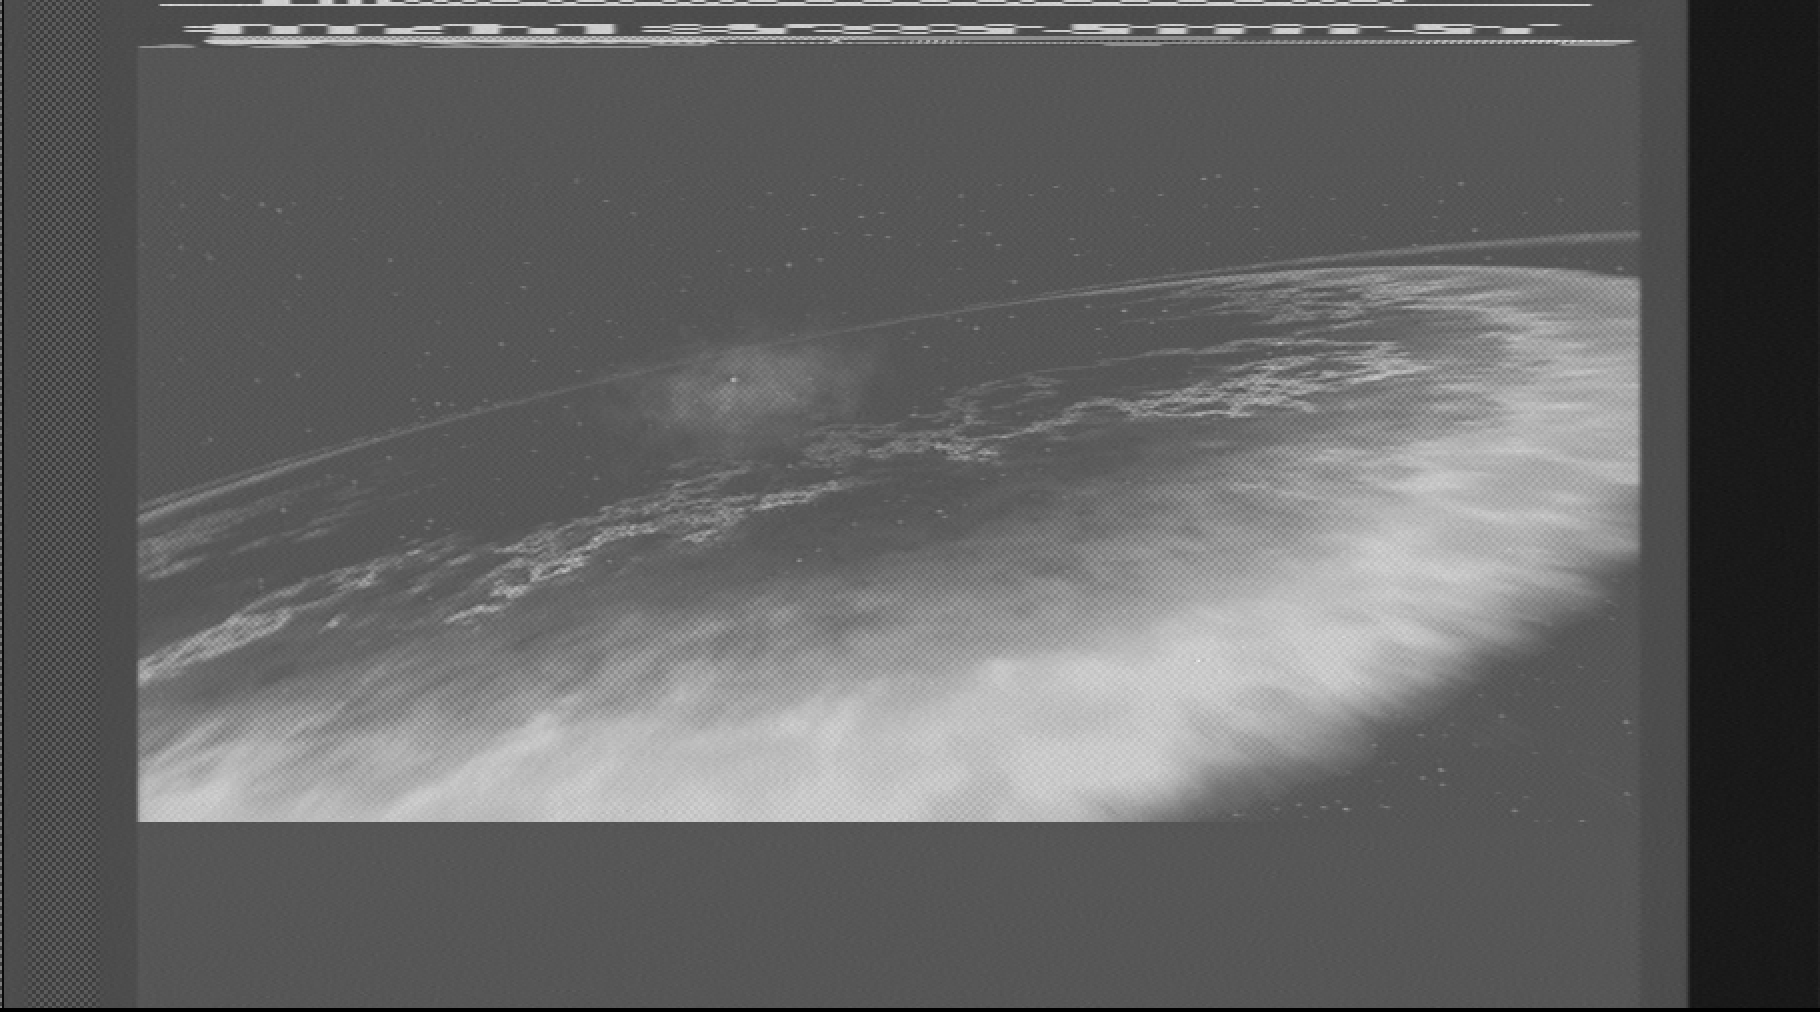

In [48]:
drawdata(output_fullframe, outwidth, 506, hscale=2, vscale=2)

29.3794425824 0.874384663182
29.3794425824 37.8287292611 37.4397444981


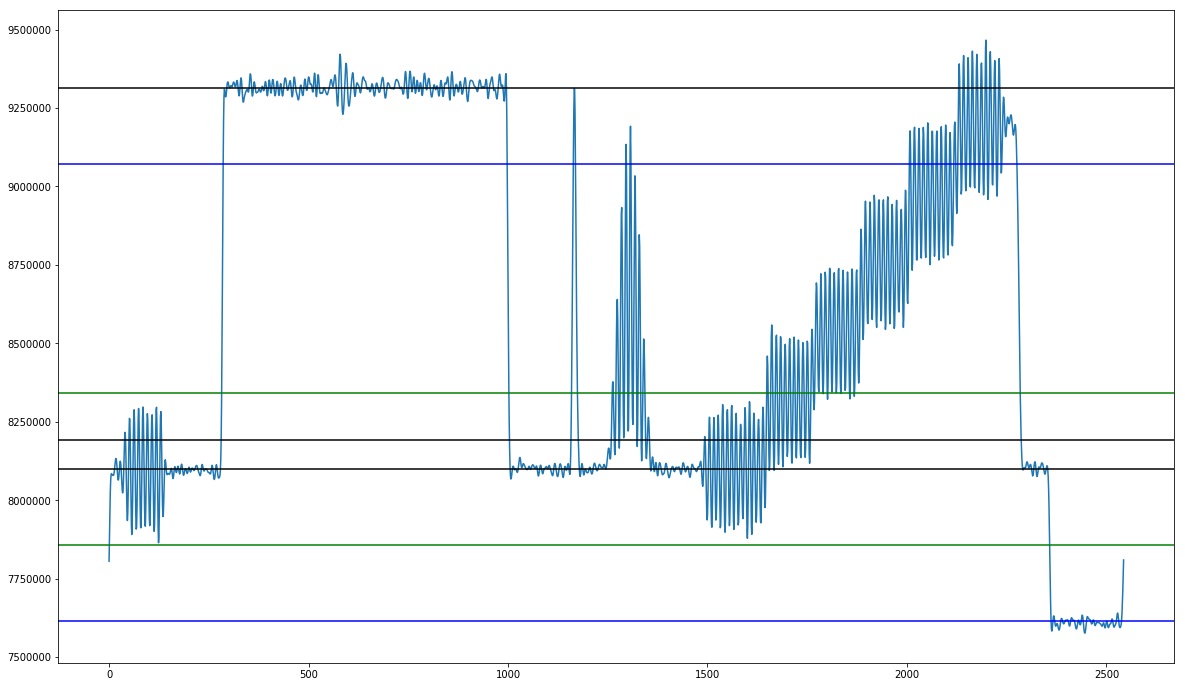

In [49]:
l = 10

bar0 = frame['demod'][int(lineinfo_even[l]):int(lineinfo_even[l+1])]
#bar0 = frame['demod'][int(lineinfo_odd[l]):int(lineinfo_odd[l+1])]
lineplot(bar0, filterset)
print(calcsnr(bar0[400:600]), (np.max(bar0[1200:1500]) - 8100000) / (bar0[500] - 8100000))
print(calcsnr(bar0[400:600]), calcsnr(bar0[1040:1150]), calcsnr(bar0[-150:-10]))


In [78]:
def inpicture(linenum):
    if linenum is None:
        return False
    
    return inrange(linenum, 10, 263.4) or inrange(linenum, 273, 525)

# this still needs to be simplified... 
def findsync_getpulses(frame, start, line_px = 2540, lines = 525):
    curloc = start
    
    output = frame['demod']
    output_sync = frame['demod_sync']

    lastline = 0
    linenum = None
    lineinfo = {}
    
    # Check every half-line for equalization pulses
    sstart = int(line_px * .45)
    send = int(line_px * .55)
    
    while linenum is None or (linenum <= 526 and ((curloc - lastline) < (lines * line_px))):
        offset = np.argmax(output_sync[curloc + sstart:curloc + send])
        lineloc = curloc + sstart + offset
        
        #lineloc = int(np.round(calczc(frame['demod'], lineloc-300, iretohz(-20), 500)))

        synclevel = output_sync[lineloc]
        
        print(linenum, inpicture(linenum), curloc, offset, lineloc, lineloc - lastline, synclevel)

        # the adjustment factor is set per line type - calibrated against an acutal disk
        adjustment = 0
        if inrange(synclevel, 0.65, 0.8) or (inpicture(linenum) and inrange(synclevel, 0.3, 0.85)): # regular line
            lastline = lineloc
            # If we're in the middle of a frame, don't scan mid-lines
            if linenum is not None and inpicture(linenum):
                curloc = lineloc + int(line_px * .5)
            else:
                curloc = lineloc
                
            # find the zero crossing of the non-filtered demod signal... or interpolate if this is wrong
            try:
                lineloc = int(np.round(calczc(output, lineloc - 10, iretohz(-20), 30)))
            except:
                lineloc = lineinfo[linenum - 1]  + (lineinfo[linenum - 1] - lineinfo[linenum - 2])
                #None
        elif inrange(synclevel, 0.4, 0.65): # equalization pulse - before and after vsync
            if not inrange(lineloc - lastline, line_px * .95, line_px * 1.05) and linenum is None:
                return None, curloc
            elif linenum is None:
                linenum = 1
            # adjust to match observed color burst timing
            adjustment = int(usectopx(2.4))
            curloc = lineloc
        elif inrange(synclevel, 0.8, 1.01): # vsync
            # vsync - DO NOT use the peak filtered sync here, it is going to be way off!
            lineloc = int(np.round(calczc(frame['demod'], lineloc-300, iretohz(-20), 500)))
            adjustment = int(usectopx(4.65))
            curloc += int(line_px * .5)
        else: # probably middle of regular line
            curloc += int(line_px * .5)
            
        if linenum is not None:
            # save integers if not a half-line
            if np.abs(linenum - np.int(linenum)) > .1:
                lineinfo[linenum] = lineloc
                print(linenum, lineloc)
            else:
                lineinfo[int(linenum)] = lineloc + adjustment
                print(linenum, lineloc + adjustment)
                
        if linenum is not None:
            if inpicture(linenum):
                linenum += 1.0
            else:
                linenum += 0.5

        
    return lineinfo, lastline

def findsync(frame, loc = 0, limit = 40 * 2800, line_px = 2540):
    loc = int(loc)
    output_sync = frame['demod_sync']

    # find the next vsync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+limit]) + loc

    if (syncloc < line_px * 8) or np.max(output_sync[syncloc:syncloc+limit]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None, None)
    
    # now rewind and get the first low hsync peak (equalization pulse 1 of 5 or 6)
    curloc = syncloc - int(line_px * 8)
    
    offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'])])
    return findsync_getpulses(frame, curloc + offset)

linelocs, end = findsync(frame, 0)

# this needs *a lot* of cleaning up
def cburstalign(frame, lineinfo, badburst, shift33 = -((33.0 / 360.0) * np.pi)):
    lineinfo_tmpa = lineinfo.copy()
    offset = 0
    
    output = frame['demod']
    output_burst = frame['demod_burst']
    
    peak = []
    cuts = []
    for l in range(1, 525):
        if badburst[l]:
            #lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue
        
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()
        
        peak.append(np.argmax(np.abs(cut)))
        
    peak = np.array(peak)
    peakmean = peak.mean()
    
    zc = []
    linelens = []
    for l in range(1, 525):
        if badburst[l]:
            continue

        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        #zc.append(calczc(cut, np.floor(peakmean), 0, 5))
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        try:
            zc.append(calczc(cut, np.floor(peakmean), 0, 5) * (outwidth / linelen))
            linelens.append(lineinfo_tmpa[l + 1] - lineinfo_tmpa[l])
        except:
            None
        
    print("zcmean ", np.mean(zc), np.mean(zc) * (outwidth / np.mean(linelens)))
        
    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, 525):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        try:
            adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (outwidth / linelen)
        except:
            print('bad burst', l, lineinfo[l], lineinfo2[l], tmp)
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offsets[l - 1] - filterset['dgap_burst']
            continue

        # find the nearest odd # for the peak crossover.
        target = (np.round((adjpeak - 1) / 2) * 2) + 1
        offsets[l] = (adjpeak - target)

        #print('fs ', l, np.argmax(cut), adjpeak, target,  offsets[l], lineinfo2[l], lineinfo_tmpa[l], lineinfo_tmpa[l] - lineinfo_tmpa[l - 1])
            
    if np.mean(np.abs(offsets)) > .8:
        print("WARNING: offsets too high")
            
    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, 524):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l, offsets[l - 1:l + 2])
            if offsets[l] > 0:
                offsets[l] -= outfsc // 2
            else:
                offsets[l] += outfsc // 2
            
    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(1, 525):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / outwidth)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / outwidth)) #- filterset['dgap_burst']    

    return lineinfo_tmpa, lineinfo_cphaseadj, offsets

badburst = np.zeros(526)
linelocs2, linelocs2_phaseadj, offsets = cburstalign(frame, linelocs, badburst)

(477750,)
uint8 (525, 910) (525, 910)


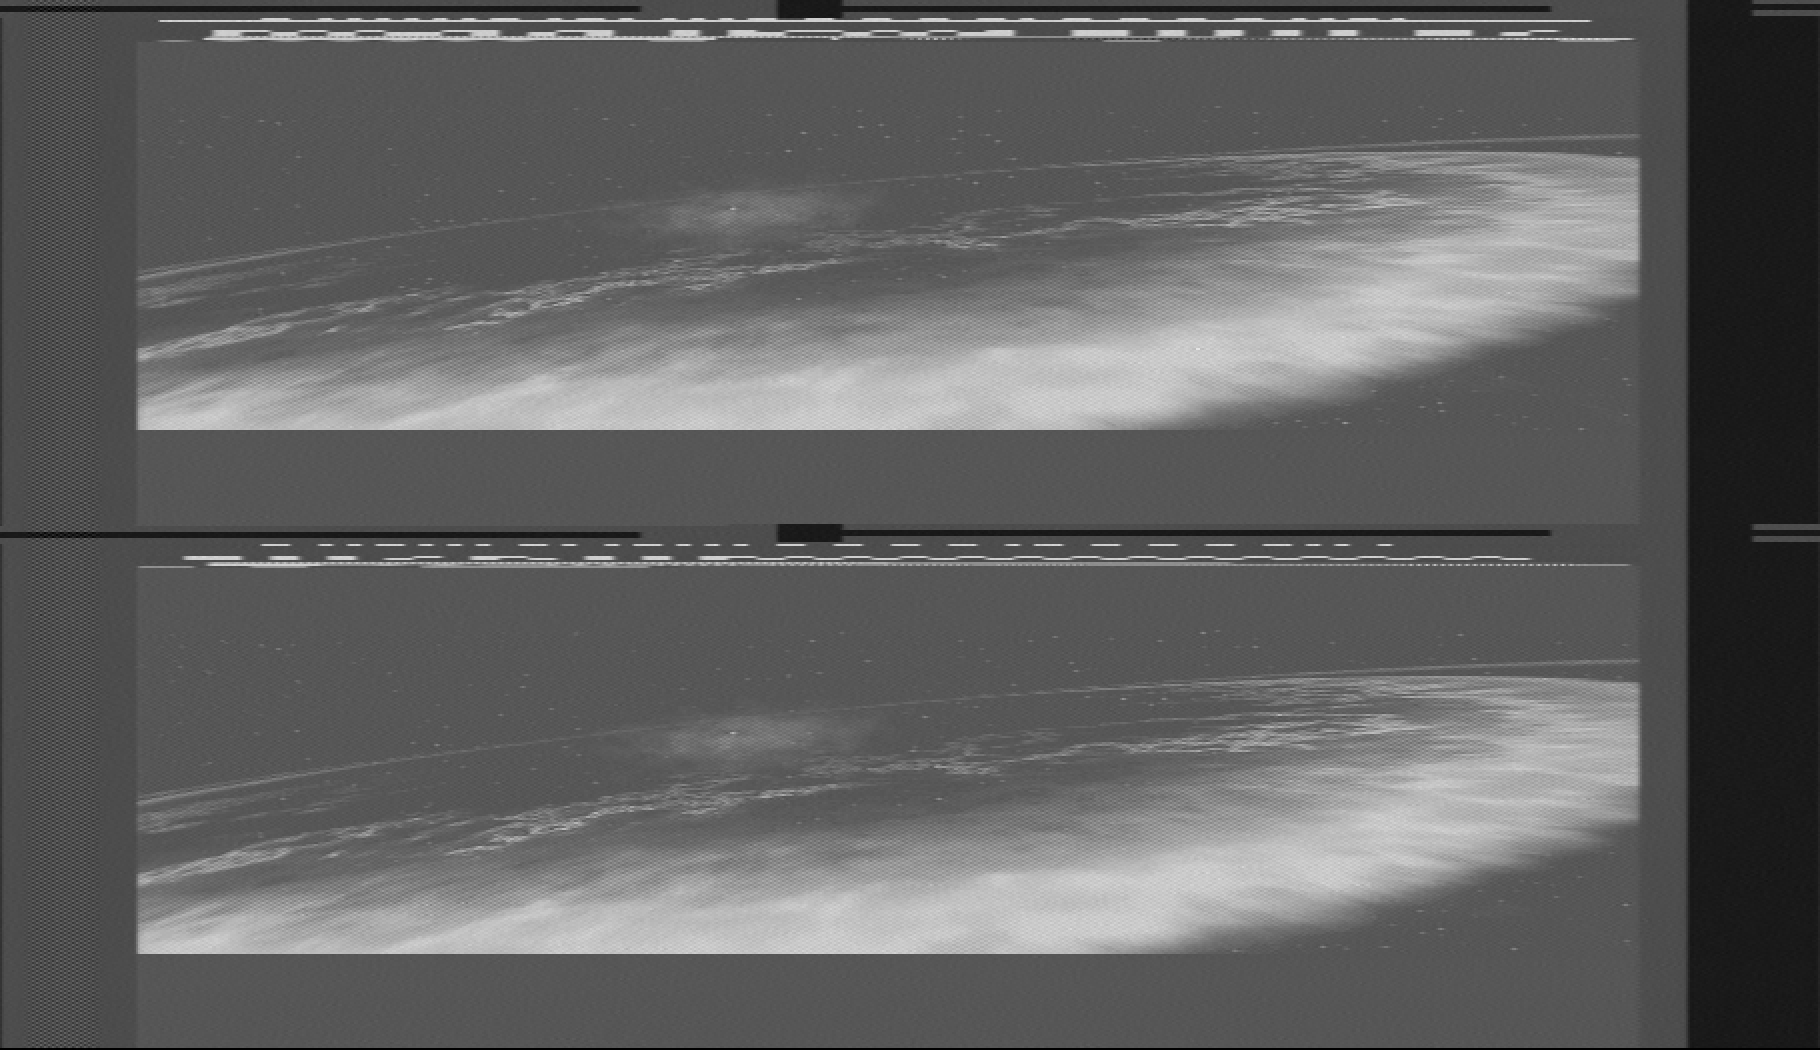

In [112]:
ll = []
outwidth = 910
dsout = np.zeros((525 * outwidth), dtype=np.double)    
for l in range(1, 525):
    ll.append(linelocs2[l])
    dsout[(l - 1) * outwidth: l * outwidth] = scale(frame['demod'], linelocs2[l], linelocs2[l+1], outwidth)

reduced = (dsout - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, outwidth, 525, hscale=2, vscale=2)

198664.5394648173

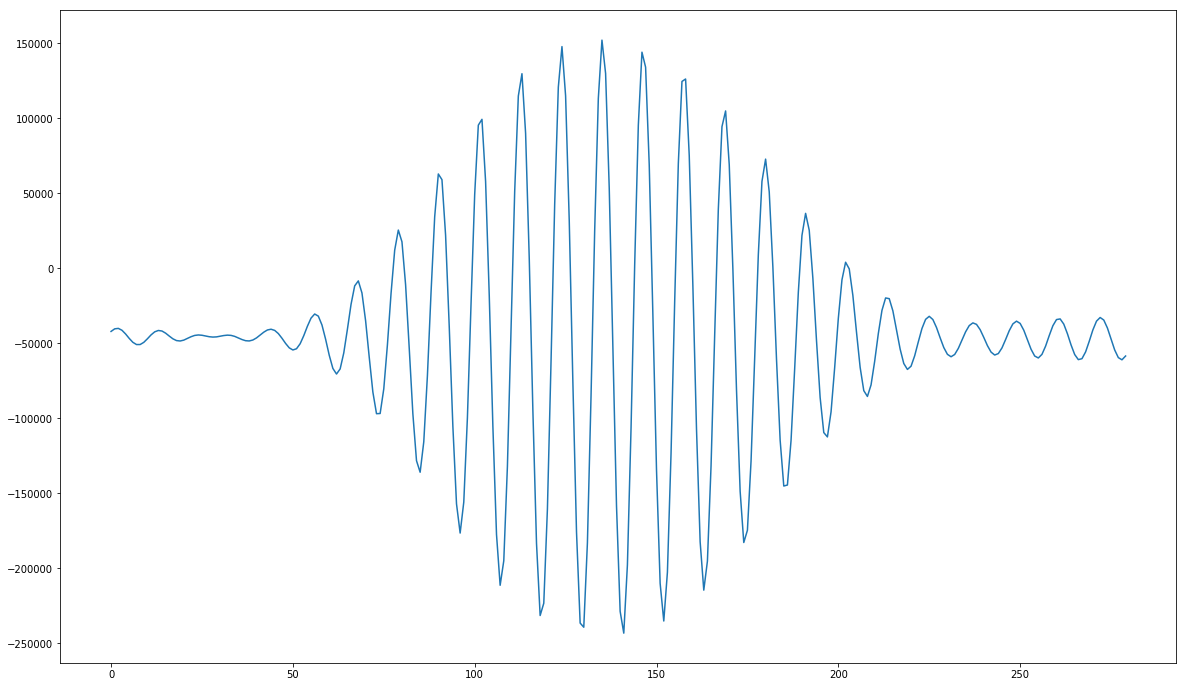

In [99]:
l = 12

bar0 = frame['demod_burst'][int(linelocs[l]):int(linelocs[l]+usectopx(7))]
plt.plot(bar0)
np.max(bar0 - np.mean(bar0))

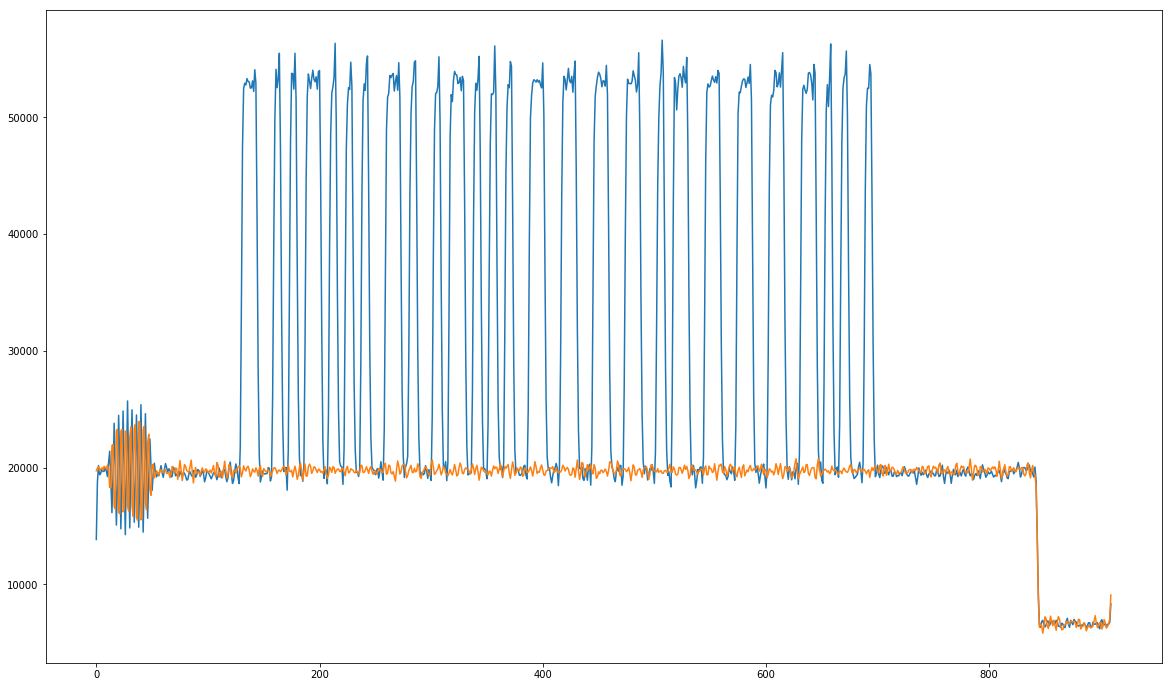

In [84]:
l = 272
plt.plot(lines16[(l * 910):(l + 1) * 910])
l = 271
plt.plot(lines16[(l * 910):(l + 1) * 910])
         